In [1]:
import cv2, time, os, numpy as np
import time
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.python.keras.utils.data_utils import get_file 

np.random.seed(123)
# https://github.com/opencv/opencv/wiki/TensorFlow-Object-Detection-API
classFile ="../coco.names" 
threshold = 0.5
is_tensorflow_model=False
perf = []


## methods declaration

### utils methods

In [2]:
def readClasses( classesFilePath,is_yolo=False): 
    global classesList
    global colorList
    global classAllowed
    classAllowed=[0,1,2,3,5,6,7]
    
    with open(classesFilePath, 'r') as f:
        classesList = f.read().splitlines()
        
    #   delete all class except person and vehiccule 
    classesList=classesList[0:8]
    classesList.pop(4)
    print(classesList)
    
    if is_yolo==False:
        classesList.insert(0,-1)
    # Colors list 
    colorList = np.random.uniform(low=0, high=255, size=(len(classesList), 3))

In [3]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

### init model methods 

In [4]:
def init_download_model_tensorflow( modelURL):
    fileName = os.path.basename(modelURL) 
    global modelName
    global cacheDir
    global model
    global is_tensorflow_model
    is_tensorflow_model=True
    modelName = fileName[:fileName.index('.')]
    cacheDir = os.path.join("..","tensorflow_model", modelName)

    os.makedirs(cacheDir, exist_ok=True)
    get_file(fname=fileName,origin=modelURL, cache_dir=cacheDir, cache_subdir="checkpoints",  extract=True)
    tf.keras.backend.clear_session()
    model = tf.saved_model.load(os.path.join(cacheDir, "checkpoints", modelName, "saved_model"))
    print("Model " + modelName + " loaded successfully...")
    readClasses(classFile,is_yolo=False)


In [5]:
def init_model_yolo(modelName_="yolov4"):
    global model
    global classFile
    global configPath
    global modelPath
    global modelName
    global is_tensorflow_model

    modelName=modelName_
    is_tensorflow_model=False
    configPath=os.path.join("../opencv_model",modelName,modelName+".cfg")
    modelPath=os.path.join("../opencv_model",modelName,modelName+".weights")
    
    net = cv2.dnn.readNet(modelPath,configPath)
    net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
    net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA_FP16)

    model=cv2.dnn_DetectionModel(net)
    model.setInputParams(size=(416, 416), scale=1/255, swapRB=True)

    readClasses(classFile,is_yolo=True)
     

In [6]:
def init_model_opencv(modelName_="ssd_mobilenet_v3_large_coco_2020_01_14"):
    global model
    global classFile
    global configPath
    global modelPath
    global modelName
    global is_tensorflow_model
    modelName=modelName_
    is_tensorflow_model=False

    configPath=os.path.join("../opencv_model",modelName,modelName+".pbtxt")
    modelPath=os.path.join("../opencv_model",modelName,"frozen_inference_graph.pb")
    model=cv2.dnn_DetectionModel(modelPath,configPath)

    model.setInputSize(320,320)
    model.setInputScale(1.0/127.5)
    model.setInputMean((127.5,127.5,127.5))
    model.setInputSwapRB(True)
    readClasses(classFile)
    

### detection methodes

In [7]:
def imageDetectionTensorflow( image,threshold= 0.5,videoFrame=False,imagePath=None):
    global model
    global classesList
    global colorList
    global detections

    inputTensor = cv2.cvtColor( image.copy(), cv2.COLOR_BGR2RGB ) 
    inputTensor = tf.convert_to_tensor(inputTensor, dtype=tf.uint8) 
    inputTensor = inputTensor[tf.newaxis,...]

    s = time.time()
    detections = model(inputTensor)
    curr_time = (time.time()-s )*1000
    if videoFrame==False :
        print(modelName )
        print("execution time : ",str(curr_time))
    
    bboxs = detections['detection_boxes'][0].numpy()
    classIndexes = detections['detection_classes'][0].numpy().astype(np.int32) 
    classScores = detections['detection_scores'][0].numpy()
    imH, imW, imC = image.shape
    bboxIdx = tf.image.non_max_suppression(bboxs, classScores, max_output_size=50, 
    iou_threshold=threshold, score_threshold=threshold)

    if imagePath != None:
        print("add pref")
        imagePerf={"framework":"Tensorflow","imagePath":imagePath,"exec_time":curr_time,"modelName":modelName,"object_detected":len(bboxIdx)}
        perf.append(imagePerf)

    if len(bboxIdx) != 0: 
        for i in bboxIdx:
            bbox = tuple(bboxs[i].tolist())
            classConfidence = round(100*classScores[i])
            classIndex = classIndexes[i]

            if (classIndex in classAllowed)==False:
                continue

            classLabelText=classesList[classAllowed.index(classIndex)]
            classColor = colorList[classAllowed.index(classIndex)]

            # classColor = colorList[classIndex]
            displayText = '{}: {}'.format(classLabelText, classConfidence) 
            ymin, xmin, ymax, xmax = bbox
            xmin, xmax, ymin, ymax = (xmin * imW, xmax * imW, ymin * imH, ymax * imH) 
            xmin, xmax, ymin, ymax = int(xmin), int(xmax), int(ymin), int(ymax)

            cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color=classColor, thickness=2) 
            cv2.putText(image, displayText, (xmin, ymin - 10), cv2.FONT_HERSHEY_PLAIN, 1, classColor, 2)
            ###############################################
    return image

In [38]:
def imageDetectionOpencv( image, threshold = 0.5,videoFrame=False,imagePath=None): 
    global model
    global modelName
    global perf

    s = time.time()
    classLabelIDs,confidences,bboxs= model.detect(image,confThreshold=threshold)
    curr_time = (time.time()-s )*1000
    if videoFrame==False :
        print(modelName )
        print("execution time : ",str(curr_time))  
        
    bboxs=list(bboxs)
    confidences=list(np.array(confidences).reshape(1,-1)[0])
    confidences=list(map(float,confidences))

    bboxIdx=cv2.dnn.NMSBoxes(bboxs,confidences,score_threshold=0.4,nms_threshold=0.2)

    if imagePath != None:
        imagePerf={"framework":"opencv","imagePath":imagePath,"exec_time":curr_time,"modelName":modelName,"object_detected":len(bboxIdx)}
        perf.append(imagePerf)
        
    if len(bboxIdx) !=0 :
        for i in range (0,len(bboxIdx)):
            
            bbox=bboxs[np.squeeze(bboxIdx[i])]
            classConfidence = confidences[np.squeeze(bboxIdx[i])]
            classLabelID=np.squeeze(classLabelIDs[np.squeeze(bboxIdx[i])])
    
            if (classLabelID in classAllowed)==False:
                continue

            classLabel=classesList[classAllowed.index(classLabelID)]
            classColor = colorList[classAllowed.index(classLabelID)]
            displayText = '{}: {:.2f}'.format(classLabel, classConfidence) 
            if videoFrame==False:
                print(displayText)
            x,y,w,h=bbox
            cv2.rectangle(image,(x,y),(x+w,y+h),color=classColor,thickness=2)
            cv2.putText(image, displayText, (x, y - 10), cv2.FONT_HERSHEY_PLAIN, 1, classColor, 2)

        return image
        
    return image

In [8]:
def predictImage( imagePath, threshold = 0.5): 
    global modelName
    image = cv2.imread(imagePath)

    if is_tensorflow_model:
        bboxImage = imageDetectionTensorflow(image, threshold,imagePath=imagePath)
    else :
        bboxImage = imageDetectionOpencv(image, threshold,imagePath=imagePath)
    pathnew="../detection_result/"+modelName + "_" + imagePath[-5:-4] + ".jpg"
    cv2.imwrite(pathnew, bboxImage) 
  
    img = cv2.cvtColor(bboxImage, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    
    print(modelName + "_" + imagePath[-5:-4]+".jpg")
    cv2.imshow("Result", bboxImage)
    cv2.waitKey(0)
    cv2.destroyAllWindows() 
    
#     global classesList
# print(classesList)

In [9]:
def predictVideo( videoPath, threshold = 0.5): 
    print(modelName )
    print("videoPath : ",str(videoPath))
        
    cap=cv2.VideoCapture(videoPath)
    if ( cap.isOpened()==False):
        print("ERROR opening file ..")
        return
    (success,image)=cap.read()
    startTime=0
    
    while success:
        currentTime=time.time()
        fps=1/(currentTime-startTime)
        startTime=currentTime
        bboxImage= imageDetectionOpencv(image, threshold,videoFrame=True)
        cv2.putText(bboxImage,"FPS : "+str(int(fps)),(20,70),cv2.FONT_HERSHEY_PLAIN,2,(0,255,0),2)
        cv2.imshow("Result",bboxImage)
        
        key=cv2.waitKey(1) & 0xFF
        if key==ord("q"):
            break
            
        (success,image)=cap.read()
    cv2.destroyAllWindows()

##  declare model & test detection 

### construct models

In [10]:
# modelName="ssd_mobilenet_v3_large_coco_2020_01_14"
init_model_opencv(modelName_="ssd_mobilenet_v3_large_coco_2020_01_14")

['person', 'bicycle', 'car', 'motorcycle', 'bus', 'train', 'truck']


In [13]:
# yolov7-tiny
# yolov4-tiny
# yolov4-csp
# yolov4
# yolov3
# yolov3-tiny
# yolov2
init_model_yolo(modelName_="yolov3")

['person', 'bicycle', 'car', 'motorcycle', 'bus', 'train', 'truck']


In [ ]:
# https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md
# modelURL = "http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_resnet50_v2_512x512_coco17_tpu-8.tar.gz"
# modelURL = "http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz"
# modelURL = "http://download.tensorflow.org/models/object_detection/tf2/20210210/centernet_mobilenetv2fpn_512x512_coco17_od.tar.gz"
# modelURL = "http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8.tar.gz"
# modelURL = "http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.tar.gz"
modelURL="http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz"
# modelURL = "http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz"
# modelURL = "http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz"
# modelURL="http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d3_coco17_tpu-32.tar.gz"
init_download_model_tensorflow(modelURL) 

In [13]:
readClasses(classFile)

['person', 'bicycle', 'car', 'motorcycle', 'bus', 'train', 'truck']


### TEST FUNCTIONs

efficientdet_d3_coco17_tpu-32
execution time :  2650.6152153015137
add pref


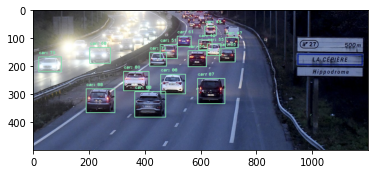

efficientdet_d3_coco17_tpu-32_1.jpg


In [14]:
imagePath = "../test/1.jpg"
predictImage( imagePath,threshold=0.4)

efficientdet_d3_coco17_tpu-32
execution time :  2808.3059787750244
add pref


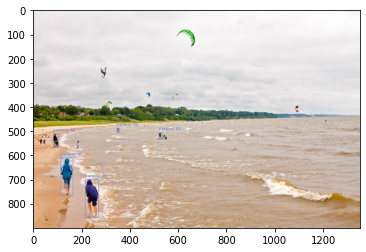

efficientdet_d3_coco17_tpu-32_5.jpg


In [15]:
imagePath = "../test/5.jpg" 
predictImage( imagePath,threshold=0.5)

efficientdet_d3_coco17_tpu-32
execution time :  2692.108392715454
add pref


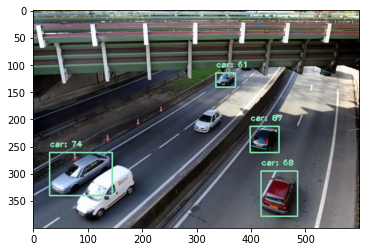

efficientdet_d3_coco17_tpu-32_4.jpg


In [16]:
imagePath = "../test/4.jpg" 
predictImage( imagePath,threshold=0.5)

In [49]:
videoPath="test/2.mp4"
predictVideo(videoPath, threshold=0.4)

yolov3
videoPath :  test/2.mp4
ERROR opening file ..


In [49]:
perf

[{'imagePath': '../test/1.jpg',
  'exec_time': 192.92354583740234,
  'modelName': 'ssd_mobilenet_v2_320x320_coco17_tpu-8',
  'object_detected': 37},
 {'framework': 'opencv',
  'imagePath': '../test/1.jpg',
  'exec_time': 157.65905380249023,
  'modelName': 'ssd_mobilenet_v3_large_coco_2020_01_14',
  'object_detected': 15},
 {'framework': 'opencv',
  'imagePath': '../test/1.jpg',
  'exec_time': 106.97102546691895,
  'modelName': 'ssd_mobilenet_v3_large_coco_2020_01_14',
  'object_detected': 15},
 {'framework': 'opencv',
  'imagePath': '../test/0.jpg',
  'exec_time': 130.75566291809082,
  'modelName': 'ssd_mobilenet_v3_large_coco_2020_01_14',
  'object_detected': 5},
 {'framework': 'Tensorflow',
  'imagePath': '../test/1.jpg',
  'exec_time': 6261.455774307251,
  'modelName': 'ssd_mobilenet_v2_320x320_coco17_tpu-8',
  'object_detected': 37},
 {'framework': 'Tensorflow',
  'imagePath': '../test/0.jpg',
  'exec_time': 951.8966674804688,
  'modelName': 'ssd_mobilenet_v2_320x320_coco17_tpu-8',